### DFTSNN - Generator Matrix Encoded dataset

The dataset is encoded using the padded generator matrix. the imaginary and real values are parellel processed until concatenation. This mimics the IDFT SNN. One additional layer is included to account for the scaling diagonal matrix $\hat{D}_n$ in the classical algorithm.

In [1]:
# (r + 1) | (q - 1)
# (r + 1) | n
# q is a prime number
# n = 2^t
# r < n

In [2]:
%reset -f
import gc
gc.collect()

0

In [3]:
import numpy as np

np.random.seed(42)

n = 16
q = 5
num_samples = 1000

def next_power_of_two(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

n_padded = next_power_of_two(n)

dataset = np.random.randint(0, q, size=(num_samples, n))

if n_padded > n:
    pad_width = n_padded - n
    dataset = np.pad(dataset, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

print("Original n:", n)
print("Padded n:", n_padded)
print("Generated dataset shape:", dataset.shape)

n = n_padded

Original n: 16
Padded n: 16
Generated dataset shape: (1000, 16)


In [4]:
print(dataset)
print(dataset.shape)
print(dataset[0].shape)

[[3 4 2 ... 1 3 1]
 [3 4 0 ... 3 2 3]
 [3 0 2 ... 0 1 4]
 ...
 [4 4 4 ... 0 2 2]
 [4 2 4 ... 4 0 0]
 [2 2 2 ... 0 4 2]]
(1000, 16)
(16,)


$$
\tilde{M}_{kj} = \left[ \left( \frac{w_0}{z_0} \right)^j \zeta^{kj} \right]_{k,j=0}^{n-1}
$$

In [5]:
def padded_generator_matrix(n, w0, z0):
    zeta = np.exp(-2j * np.pi / n)
    M_tilde = np.array([[(w0 / z0) ** j * zeta**(k * j) for j in range(n)] for k in range(n)], dtype=complex)
    return M_tilde

In [6]:
# (x, y, z, w) --> (1, 2, 3, 4)
w0 = 4
z0 = 3

M_tilde = padded_generator_matrix(n, w0, z0)
print(M_tilde.shape)

(16, 16)


In [7]:
encoded_dataset = np.array([np.dot(M_tilde, x) for x in dataset])
encoded_dataset[np.abs(encoded_dataset) < 1e-10] = 0
encoded_dataset = np.round(encoded_dataset, decimals=10)
print(encoded_dataset)

[[ 649.89449698  +0.j           69.97998169+371.13335899j
   -83.92481787+137.40000024j ...  -88.37954911-103.22398682j
   -83.92481787-137.40000024j   69.97998169-371.13335899j]
 [ 695.87003951  +0.j          268.59479107+394.57072111j
   -36.50274968+309.16102475j ...  -47.36788425-179.88976988j
   -36.50274968-309.16102475j  268.59479107-394.57072111j]
 [ 540.63797786  +0.j          235.29809241+209.31041098j
   176.66145652+204.71795948j ...  108.87153914-320.22828928j
   176.66145652-204.71795948j  235.29809241-209.31041098j]
 ...
 [ 460.45123158  +0.j          162.64910275+168.11969395j
    54.45039471+219.81284778j ...  -26.91067254-124.72256855j
    54.45039471-219.81284778j  162.64910275-168.11969395j]
 [ 558.17613119  +0.j          -92.41727316+362.85897707j
  -228.64175513 +13.85662093j ...  -76.51498185+176.39278765j
  -228.64175513 -13.85662093j  -92.41727316-362.85897707j]
 [ 671.99178181  +0.j          161.97417378+352.04621278j
    43.09272997+244.01831359j ...  -56.208

In [8]:
print(encoded_dataset.shape)

(1000, 16)


In [9]:
print(dataset[0])
print(encoded_dataset[0])

[3 4 2 4 4 1 2 2 2 4 3 2 4 1 3 1]
[ 649.89449698  +0.j           69.97998169+371.13335899j
  -83.92481787+137.40000024j  -88.37954911+103.22398682j
  -74.53901813 +41.73652084j  -97.48254893 +37.96448017j
 -147.95858217-108.15626408j   47.97234649-148.66691513j
  146.76987906  -0.j           47.97234649+148.66691513j
 -147.95858217+108.15626408j  -97.48254893 -37.96448017j
  -74.53901813 -41.73652084j  -88.37954911-103.22398682j
  -83.92481787-137.40000024j   69.97998169-371.13335899j]


In [10]:
# Normalize to zero mean and unit variance - output results of normalizing made unseen data converge to q-1
# encoded_dataset = (encoded_dataset - np.mean(encoded_dataset, axis=0)) / np.std(encoded_dataset, axis=0)
# print(encoded_dataset[0])

In [11]:
X_real = np.real(encoded_dataset).astype(np.float32)
X_imag = np.imag(encoded_dataset).astype(np.float32)

print("\nX_train_real :", X_real.shape)
print(X_real[0])
print("\nX_train_imag :", X_imag.shape)
print(X_imag[0])


X_train_real : (1000, 16)
[ 649.8945     69.97998   -83.92482   -88.37955   -74.53902   -97.48255
 -147.95859    47.972347  146.76988    47.972347 -147.95859   -97.48255
  -74.53902   -88.37955   -83.92482    69.97998 ]

X_train_imag : (1000, 16)
[   0.        371.13336   137.4       103.22398    41.736523   37.96448
 -108.156265 -148.66692    -0.        148.66692   108.156265  -37.96448
  -41.736523 -103.22398  -137.4      -371.13336 ]


In [12]:
# normalize target data (integers 0-q to [0, 1])
y_normalized = dataset.astype(np.float32) / (q - 1)  # Scale to [0, 1]
print("y: ")
print(dataset.astype(np.float32)[0])
print("\ny_normalized: ")
print(y_normalized[0])

labels = y_normalized

y: 
[3. 4. 2. 4. 4. 1. 2. 2. 2. 4. 3. 2. 4. 1. 3. 1.]

y_normalized: 
[0.75 1.   0.5  1.   1.   0.25 0.5  0.5  0.5  1.   0.75 0.5  1.   0.25
 0.75 0.25]


In [13]:
from sklearn.model_selection import train_test_split

X_real_train, X_real_test, y_train, y_test = train_test_split(
    X_real, labels, test_size=0.2, random_state=42
)

X_imag_train, X_imag_test, _, _ = train_test_split(
    X_imag, labels, test_size=0.2, random_state=42
)

print("Training data shapes: X_real:", X_real_train.shape, "X_imag:", X_imag_train.shape, "y:", y_train.shape)
print("Testing data shapes: X_real:", X_real_test.shape, "X_imag:", X_imag_test.shape, "y:", y_test.shape)

Training data shapes: X_real: (800, 16) X_imag: (800, 16) y: (800, 16)
Testing data shapes: X_real: (200, 16) X_imag: (200, 16) y: (200, 16)


In [14]:
print(X_real_train.shape[1])
print(X_real_test.shape[1])
print(X_imag_train.shape[1])
print(X_imag_test.shape[1])
print(y_train.shape[1])
print(y_test.shape[1])

16
16
16
16
16
16


In [15]:
input_dim = X_real_train.shape[1]
output_dim = y_train.shape[1]
print(input_dim)
print(output_dim)

16
16


IDFT - Structure Imposed Neural Network

In [16]:
import tensorflow as tf

In [17]:
class FirstLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(FirstLayer, self).__init__(**kwargs)
        self.units = units  # Features/neurons
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        n1 = n // 2
        num_blocks = n1 // 2

        self.b_1 = self.add_weight(name="kernel_b1",
                                   shape=(num_blocks, 2, 2),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                   trainable=True)
        self.b_2 = self.add_weight(name="kernel_b2",
                                   shape=(num_blocks, 2, 2),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                   trainable=True)
        self.d_1 = self.add_weight(name="kernel_d1",
                                   shape=(n1 - 2,),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                   trainable=True)
        self.d_2 = self.add_weight(name="kernel_d2",
                                   shape=(n1 - 2,),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                   trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name="bias",
                                        shape=(self.units,),
                                        initializer=tf.keras.initializers.get(self.bias_initializer),
                                        trainable=True)

    def call(self, inputs):
        def recursiveIDFT(inputVector, B, d, level):
            n = inputVector.shape[1]
            n1 = n // 2

            if n == 2:
                out = tf.matmul(inputVector, B[level])
                return out
            else:
                q = tf.concat([inputVector[:, ::2], inputVector[:, 1::2]], axis=1)

                B1 = recursiveIDFT(q[:, :n1], B, d[n1:], level + 1)
                B2 = recursiveIDFT(q[:, n1:], B, d[n1:], level + 1)

                d_n = tf.reshape(d[:n1], (1, -1))
                z1 = tf.concat([(B1 + tf.multiply(B2, d_n)), (B1 - tf.multiply(B2, d_n))], axis=1)

                return z1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))

        n = self.units
        n1 = n // 2

        q = tf.concat([inputs[:, ::2], inputs[:, 1::2]], axis=1)

        B1 = recursiveIDFT(q[:, :n1], self.b_1, self.d_1, level=0)
        B2 = recursiveIDFT(q[:, n1:], self.b_2, self.d_2, level=0)

        out = tf.concat([B1, B2], axis=1)

        if self.use_bias:
            out += self.bias

        return out

In [18]:
class SecondLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(SecondLayer, self).__init__(**kwargs)
        self.units = units  # Features/neurons
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        n1 = n // 2

        self.d_1 = self.add_weight(name="kernel_d1",
                                   shape=(n1,),
                                   initializer=tf.keras.initializers.get(self.kernel_initializer),
                                   trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name="bias",
                                        shape=(n,),
                                        initializer=tf.keras.initializers.get(self.bias_initializer),
                                        trainable=True)

    def call(self, inputs):
        out1 = inputs[:, :int(inputs.shape[1] / 2)]
        out2 = inputs[:, int(inputs.shape[1] / 2):]

        z1 = tf.concat([(out1 + tf.multiply(out2, self.d_1)), (out1 - tf.multiply(out2, self.d_1))], axis=1)
        out = z1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))

        if self.use_bias:
            out += self.bias

        return out

In [19]:
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.units = units  # features/neurons
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units

        self.m = self.add_weight(name="kernel_m",
                                 shape=(n,),
                                 initializer=tf.keras.initializers.get(self.kernel_initializer),
                                 trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name="bias",
                                        shape=(self.units,),
                                        initializer=tf.keras.initializers.get(self.bias_initializer),
                                        trainable=True)

    def call(self, inputs):
        out = tf.multiply(inputs, self.m)
        if self.use_bias:
            out += self.bias
        return out

In [20]:
class LinearLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='ones', bias_initializer='zeros', use_bias=True, **kwargs):
        super(LinearLayer, self).__init__(**kwargs)
        self.units = units
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units

        self.m = self.add_weight(name="kernel_m_1",
                                 shape=(n,),
                                 initializer=tf.keras.initializers.get(self.kernel_initializer),
                                 trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name="bias",
                                        shape=(self.units,),
                                        initializer=tf.keras.initializers.get(self.bias_initializer),
                                        trainable=True)

    def call(self, inputs):
        print("linear layer input:", inputs.shape)

        inputs1 = inputs[:, :int(inputs.shape[1] / 2)]
        inputs2 = inputs[:, int(inputs.shape[1] / 2):]

        out = tf.math.sqrt(inputs1**2 + inputs2**2)
        out = tf.multiply(out, self.m)

        if self.use_bias:
            out += self.bias

        print("linear layer output:", out.shape)
        return out

Build Model

In [21]:
from tensorflow.keras.initializers import Initializer

class CustomScalingInitializer(Initializer):
    def __init__(self, n, w0, z0):
        self.n = n
        self.w0 = w0
        self.z0 = z0

    def __call__(self, shape, dtype=None):
        return tf.convert_to_tensor([(self.z0 / self.w0) ** k for k in range(self.n)], dtype=dtype)

    def get_config(self):
        return {"n": self.n, "w0": self.w0, "z0": self.z0}


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

def cosine_loss(y_true, y_pred):
    y_true_norm = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_norm = tf.nn.l2_normalize(y_pred, axis=-1)
    return 1 - tf.reduce_mean(tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1))

def mse_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse

def hybrid_loss(y_true, y_pred):
    mse_part = tf.reduce_mean(tf.square(y_true - y_pred))
    cos_part = cosine_loss(y_true, y_pred)
    return 0.4* mse_part + 0.6 * cos_part


def structured_NN(input_dim, output_dim):
    real_input = Input(shape=(input_dim,), name="real_input")
    imag_input = Input(shape=(input_dim,), name="imag_input")
    
    # he_normal
    # glorot_normal
    # glorot_uniform
    
    real_x = FirstLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="real_layer1")(real_input)
    real_x = LeakyReLU(alpha=0.1)(real_x)
    real_x = CustomLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="real_support_layer_1")(real_x)
    real_x = LeakyReLU(alpha=0.1)(real_x)
    real_x = SecondLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="real_layer2")(real_x)
    real_x = LeakyReLU(alpha=0.1)(real_x)

    imag_x = FirstLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="imag_layer1")(imag_input)
    imag_x = LeakyReLU(alpha=0.1)(imag_x)
    imag_x = CustomLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="imag_support_layer_1")(imag_x)
    imag_x = LeakyReLU(alpha=0.1)(imag_x)
    imag_x = SecondLayer(units=input_dim, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="imag_layer2")(imag_x)
    imag_x = LeakyReLU(alpha=0.1)(imag_x)

    merged = Concatenate(name="merge_real_imag")([real_x, imag_x])
    
    # output = CustomLayer(units=input_dim * 2, kernel_initializer=CustomScalingInitializer(n=input_dim * 2, w0=w0, z0=z0), 
    #                      bias_initializer='zeros', name="diagonal_scaling_layer")(merged)
    output = CustomLayer(units=input_dim * 2, kernel_initializer='glorot_normal', bias_initializer='glorot_uniform', name="diagonal_scaling_layer")(merged)
    output = LeakyReLU(alpha=0.1)(output)
    output = LinearLayer(units=output_dim, kernel_initializer='ones', bias_initializer='zeros', name="output_layer")(output)
    output = Activation('linear')(output) # sigmoid # tanh

    model = Model(inputs=[real_input, imag_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss, metrics=['mse', 'mae'])

    return model

input_dim = X_real_train.shape[1]
output_dim = y_train.shape[1]
model = structured_NN(input_dim, output_dim)
model.summary()


linear layer input: (None, 32)
linear layer output: (None, 16)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 real_input (InputLayer)     [(None, 16)]                 0         []                            
                                                                                                  
 imag_input (InputLayer)     [(None, 16)]                 0         []                            
                                                                                                  
 real_layer1 (FirstLayer)    (None, 16)                   60        ['real_input[0][0]']          
                                                                                                  
 imag_layer1 (FirstLayer)    (None, 16)                   60        ['imag_input[0][0]']          
                              

In [23]:
for layer in model.layers:
    print(layer.name, layer.output_shape)

real_input [(None, 16)]
imag_input [(None, 16)]
real_layer1 (None, 16)
imag_layer1 (None, 16)
leaky_re_lu (None, 16)
leaky_re_lu_3 (None, 16)
real_support_layer_1 (None, 16)
imag_support_layer_1 (None, 16)
leaky_re_lu_1 (None, 16)
leaky_re_lu_4 (None, 16)
real_layer2 (None, 16)
imag_layer2 (None, 16)
leaky_re_lu_2 (None, 16)
leaky_re_lu_5 (None, 16)
merge_real_imag (None, 32)
diagonal_scaling_layer (None, 32)
leaky_re_lu_6 (None, 32)
output_layer (None, 16)
activation (None, 16)


Train Model

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

adjust_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [25]:
history = model.fit(
    [X_real_train, X_imag_train],
    y_train,
    epochs=500,
    batch_size=16,
    validation_data=([X_real_test, X_imag_test], y_test),
    callbacks=[adjust_lr, early_stopping]
)

Epoch 1/500
linear layer input: (16, 32)
linear layer output: (16, 16)


linear layer input: (16, 32)
linear layer output: (16, 16)
35/50 [====================>.........] - ETA: 0s - loss: 0.2784 - mse: 0.2290 - mae: 0.3910 linear layer input: (None, 32)
linear layer output: (None, 16)
50/50 [==============================] - 6s 27ms/step - loss: 0.2632 - mse: 0.2213 - mae: 0.3848 - val_loss: 0.2141 - val_mse: 0.1939 - val_mae: 0.3638 - lr: 0.0010
Epoch 2/500
50/50 [==============================] - 0s 5ms/step - loss: 0.1991 - mse: 0.1893 - mae: 0.3589 - val_loss: 0.1879 - val_mse: 0.1775 - val_mae: 0.3487 - lr: 0.0010
Epoch 3/500
50/50 [==============================] - 0s 5ms/step - loss: 0.1823 - mse: 0.1749 - mae: 0.3462 - val_loss: 0.1764 - val_mse: 0.1642 - val_mae: 0.3380 - lr: 0.0010
Epoch 4/500
50/50 [==============================] - 0s 5ms/step - loss: 0.1721 - mse: 0.1615 - mae: 0.3358 - val_loss: 0.1670 - val_mse: 0.1516 - val_mae: 0.3276 - lr: 0.0010
Epoch 5/500
50/50 [=

Evaluate Model

In [26]:
test_loss, test_mse, test_mae = model.evaluate([X_real_test, X_imag_test], y_test)
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

7/7 [==============================] - 0s 3ms/step - loss: 0.0651 - mse: 0.0524 - mae: 0.1540
Test MSE: 0.0524, Test MAE: 0.1540


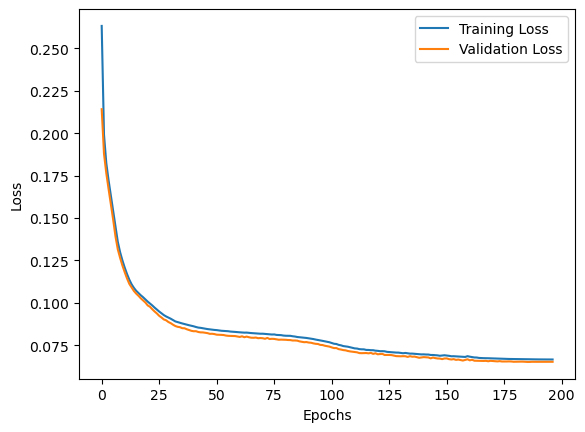

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
y_pred_test = model.predict([X_real_test, X_imag_test])
y_pred_test_rescaled = y_pred_test * (q - 1)
# y_pred_test_rescaled = (y_pred_test * y_std) + y_mean
y_test_rescaled = y_test * (q - 1)

print("Comparison of predictions and ground truth:")
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"predicted as is: ", y_pred_test[i])
    print(f"  Predicted:    {np.round(y_pred_test_rescaled[i])}")
    print(f"  Ground Truth: {np.round(y_test_rescaled[i])}")
    print("-" * 40)

linear layer input: (None, 32)
linear layer output: (None, 16)
7/7 [==============================] - 1s 3ms/step
Comparison of predictions and ground truth:
Sample 1:
predicted as is:  [0.3081977  0.43762112 0.5222944  0.44948462 0.51243275 0.3850971
 0.49161944 0.19546765 0.22147128 0.46213377 0.33397958 0.6160693
 0.27570754 0.2619928  0.98199797 0.4707925 ]
  Predicted:    [1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 1. 2. 1. 1. 4. 2.]
  Ground Truth: [1. 0. 1. 1. 1. 1. 3. 0. 1. 3. 1. 2. 1. 1. 4. 2.]
----------------------------------------
Sample 2:
predicted as is:  [0.48487183 0.4757967  0.4518394  0.4962391  0.53668135 0.4186362
 0.46533835 0.3263958  0.21120843 0.48772413 0.57240283 0.45246238
 0.7621021  0.0230394  0.2492784  0.00881121]
  Predicted:    [2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 3. 0. 1. 0.]
  Ground Truth: [4. 0. 2. 0. 2. 0. 3. 2. 1. 2. 2. 2. 3. 0. 1. 0.]
----------------------------------------
Sample 3:
predicted as is:  [ 0.54759455  0.5126716   0.45242238  0.4887147   0.548

predict on unseen data

In [29]:
num_unseen_samples = 5
unseen_data = np.random.randint(0, q, size=(num_unseen_samples, n))
padded_unseen_data = np.hstack((unseen_data, np.zeros((num_unseen_samples, n_padded - n))))
unseen_data_normalized = unseen_data.astype(np.float32) / (q - 1)

# print("Unseen Input Data (Before Encoding):")
# print(unseen_data)

unseen_encoded = np.array([np.dot(M_tilde, x) for x in padded_unseen_data])
unseen_encoded[np.abs(unseen_encoded) < 1e-10] = 0
unseen_encoded = np.round(unseen_encoded, decimals=10)

X_real_unseen = np.real(unseen_encoded).astype(np.float32)
X_imag_unseen = np.imag(unseen_encoded).astype(np.float32)

print("\nEncoded Unseen Data (Real and Imaginary Parts):")
print("Real Part Shape:", X_real_unseen.shape)
print("Imaginary Part Shape:", X_imag_unseen.shape)

y_pred_unseen = model.predict([X_real_unseen, X_imag_unseen])

y_pred_unseen_rescaled = y_pred_unseen * (q - 1)

y_pred_unseen_final = np.mod(np.round(y_pred_unseen_rescaled), q)

print("\nComparison of Unseen Data and Predictions:")
print("=" * 60)
for i in range(num_unseen_samples):
    print(f"Sample {i+1}:")
    print(f"  Prediction  : {y_pred_unseen_final[i].astype(int)}")
    print(f"  Ground Truth: {unseen_data[i]}")
    print("-" * 60)


Encoded Unseen Data (Real and Imaginary Parts):
Real Part Shape: (5, 16)
Imaginary Part Shape: (5, 16)
1/1 [==============================] - 0s 37ms/step

Comparison of Unseen Data and Predictions:
Sample 1:
  Prediction  : [3 2 2 2 2 1 1 2 4 2 2 4 2 2 4 4]
  Ground Truth: [2 3 2 1 0 0 0 4 4 1 2 4 2 2 4 4]
------------------------------------------------------------
Sample 2:
  Prediction  : [2 2 2 2 2 2 2 3 3 1 2 1 0 3 3 0]
  Ground Truth: [1 3 0 4 4 2 3 4 3 0 2 1 0 3 3 0]
------------------------------------------------------------
Sample 3:
  Prediction  : [2 2 2 2 2 2 2 4 2 4 3 3 2 3 2 1]
  Ground Truth: [3 1 1 3 3 1 3 4 2 4 3 3 2 3 2 1]
------------------------------------------------------------
Sample 4:
  Prediction  : [2 2 2 2 1 2 3 0 3 1 0 4 0 4 1 3]
  Ground Truth: [2 2 4 3 1 0 2 0 3 2 0 4 0 4 1 3]
------------------------------------------------------------
Sample 5:
  Prediction  : [1 2 2 2 2 2 2 1 0 1 4 4 4 1 2 2]
  Ground Truth: [0 2 3 0 2 2 2 2 0 1 4 4 4 1 2 2]
------

Check gradient flow

In [30]:
for layer in model.layers:
    if layer.trainable_variables:
        grads = tf.reduce_mean(tf.abs(layer.trainable_variables[0]))
        print(layer.name, "Gradient Mean:", grads.numpy())
    else:
        print(layer.name, "has no trainable variables.")

real_input has no trainable variables.
imag_input has no trainable variables.
real_layer1 Gradient Mean: 0.31840104
imag_layer1 Gradient Mean: 0.29495806
leaky_re_lu has no trainable variables.
leaky_re_lu_3 has no trainable variables.
real_support_layer_1 Gradient Mean: 0.48576808
imag_support_layer_1 Gradient Mean: 0.3677332
leaky_re_lu_1 has no trainable variables.
leaky_re_lu_4 has no trainable variables.
real_layer2 Gradient Mean: 0.6274698
imag_layer2 Gradient Mean: 0.5567539
leaky_re_lu_2 has no trainable variables.
leaky_re_lu_5 has no trainable variables.
merge_real_imag has no trainable variables.
diagonal_scaling_layer Gradient Mean: 0.43636677
leaky_re_lu_6 has no trainable variables.
output_layer Gradient Mean: 1.3726172
activation has no trainable variables.


In [31]:
batch_size = 4 
X_real_dummy = np.random.rand(batch_size, X_real_train.shape[1]).astype(np.float32)
X_imag_dummy = np.random.rand(batch_size, X_imag_train.shape[1]).astype(np.float32)
y_dummy = np.random.rand(batch_size, y_train.shape[1]).astype(np.float32)

def check_gradients(model, X_real_dummy, X_imag_dummy, y_dummy):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        predictions = model([X_real_dummy, X_imag_dummy], training=True)
        loss = tf.keras.losses.mean_squared_error(y_dummy, predictions)

    grads = tape.gradient(loss, model.trainable_variables)

    for i, (grad, var) in enumerate(zip(grads, model.trainable_variables)):
        if grad is None:
            print(f"🚨 Gradient is None for {var.name} at index {i}")
        else:
            print(f"✅ Gradient OK for {var.name}, mean: {tf.reduce_mean(grad).numpy()}")

check_gradients(model, X_real_dummy, X_imag_dummy, y_dummy)


linear layer input: (4, 32)
linear layer output: (4, 16)
✅ Gradient OK for real_layer1/kernel_b1:0, mean: 5.071519990451634e-05
✅ Gradient OK for real_layer1/kernel_b2:0, mean: 0.00010039917106041685
✅ Gradient OK for real_layer1/kernel_d1:0, mean: 0.003307051258161664
✅ Gradient OK for real_layer1/kernel_d2:0, mean: 5.9373942349338904e-05
✅ Gradient OK for real_layer1/bias:0, mean: 0.0015068321954458952
✅ Gradient OK for imag_layer1/kernel_b1:0, mean: 0.00029691256349906325
✅ Gradient OK for imag_layer1/kernel_b2:0, mean: 0.00023999929544515908
✅ Gradient OK for imag_layer1/kernel_d1:0, mean: 6.740874232491478e-05
✅ Gradient OK for imag_layer1/kernel_d2:0, mean: 6.896765989949927e-05
✅ Gradient OK for imag_layer1/bias:0, mean: -0.0015458695124834776
✅ Gradient OK for real_support_layer_1/kernel_m:0, mean: 0.006629172246903181
✅ Gradient OK for real_support_layer_1/bias:0, mean: 0.0055859703570604324
✅ Gradient OK for imag_support_layer_1/kernel_m:0, mean: 0.0184511449187994
✅ Gradient